In [2]:
import os
import sys
import scipy
from keras.models import load_model
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import scipy.io as sio
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import scipy.misc as sm
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import time

Using TensorFlow backend.


In [3]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [80]:
input_base = 'D:/2019/4DSTEM/CNN/Exp_PACBED/071618_S9/'
label_array = np.load(input_base + 'SrPeaks_thickness.npy')
pred_array = np.load(input_base + 'prediction_r6_coarse_regression.npy')
print(np.transpose(label_array) - pred_array/0.3905)
print(np.transpose(label_array))
print(pred_array/0.3905)

[[-6.44937134 -5.00202942 -5.76105118 -7.13991547 -6.30451584 -3.5805645
  -3.8391819  -4.58436584 -3.51253891 -4.03534508 -4.14590073 -5.03926086
  -4.35981941 -3.07522774 -1.61411667 -3.92093277 -3.64339066 -4.76631165
  -5.82550049 -3.97928619 -2.44596672 -4.17967415 -3.46742439 -3.40831375
  -3.8659153  -4.70022583 -3.99236679 -3.85302544 -1.83694077  0.95634651
  -1.15028191 -4.67853355 -3.47757721]]
[[24. 25. 24. 23. 26. 27. 25. 24. 25. 25. 25. 25. 24. 24. 25. 23. 24. 25.
  23. 23. 24. 22. 24. 23. 22. 21. 23. 24. 24. 26. 24. 22. 24.]]
[30.449371 30.00203  29.761051 30.139915 32.304516 30.580564 28.839182
 28.584366 28.512539 29.035345 29.1459   30.03926  28.35982  27.075228
 26.614117 26.920933 27.64339  29.766312 28.8255   26.979286 26.445967
 26.179674 27.467424 26.408314 25.865915 25.700226 26.992367 27.853025
 25.83694  25.043653 25.150282 26.678534 27.477577]


C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:85: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


59.23284912109375
Radius: 70.0, MSE: 1.61
57.1127028465271
Radius: 105.0, MSE: 1.98
59.16192865371704
Radius: 140.0, MSE: 2.02
(1361,)
Total 1361 samples.


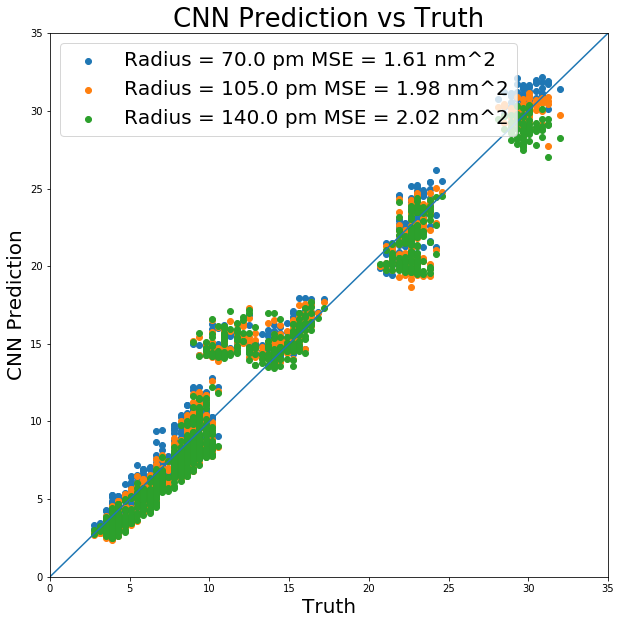

In [5]:
case = 'coarse regression'
# num_classes = 51
num_classes = 18    # For regression
class_thickness = 0.3905 * 5    # thickness step for each class in nm
batch_size = 36     # batch size during training
tilt_option = 1     # 0 to skip data with tilted PACBED
distorted_option = 1  # 0 to skip data with distorted PACBED
save_option = 1     # 0 to do plot only, 1 to save truth and prediction array for further plotting
# prediction range in nm
min_pred = 0
max_pred = 36
input_base = 'D:/2019/4DSTEM/CNN/Exp_PACBED/*/'
if 'classification' in case:
    if 'fine' in case:
        model_path = 'D:/2018/CNN/Predictions/072618_extra_dense_retrain/FinalOne/' # path for fine sampling network
    elif 'coarse' in case:
        model_path = 'D:/2018/CNN/Predictions/CoarseSample/FinalOne/'  # '/srv/home/lerandc/CNN/models/071718_combined_noise/noise100_with_noiseless/'
elif 'regression' in case:
    if 'fine' in case:
        model_path = 'D:/2019/4DSTEM/CNN/Models/Regression/FullTraining/Dense_layer_size/sz512/'  # Regression model that does not working well
    elif 'coarse' in case:
        model_path = 'D:/2019/4DSTEM/CNN/Models/Regression/CoarseCNN/PartialTraining/35nm/attempt_5/'   # Regression model for coarse CNN
#         model_path = 'D:/2019/4DSTEM/CNN/Jie training/'

# out_name = 'D:/2019/4DSTEM/CNN/Exp_Tilted/033119_S8/FinePrediction.npy'  # '071718_noise100_with_noiseless_predictions.mat'
radius_list = [4,6,8]

# Load model:
model = load_model(model_path + 'FinalModel.h5')

# Set up figure:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(111)
plt.title('CNN Prediction vs Truth',fontsize=26)

# Loop over all radii
for iradius in range(len(radius_list)):
    start = time.time()
#     num_series = 0
#     flag = 0
    radius = radius_list[iradius]
    x_train_list = []
    y_train_list = []

    # Loop over all folders (thicknesses)
    for ifolder in range(len(glob(input_base))):
#         flag = 0
        input_folder = glob(input_base)[ifolder]

        if 'tilt' in input_folder and tilt_option == 0:
            continue
            
        if 'distorted' in input_folder and distorted_option == 0:
            continue

        input_images = [image for image in os.listdir(input_folder) if 'radius_' + str(radius) + '.npy' in image]
#         print(input_folder)
        # Confirm this folder has and only has one file related to target radius:
        if len(input_images)==1:
            input_images = input_images[0]

            img_array = np.load(input_folder + input_images)
            label_array = np.load(input_folder + 'SrPeaks_thickness.npy')   # in unit of unit cells

            # prepare data to be looped through
            img_array = img_array.astype('double')
            im_range = img_array.shape[2]
            for i in range(im_range):
                label = label_array[i]  # label in uc
#                 if label * 0.3905 > 50:
#                     print(input_folder)
                if label * 0.3905 > max_pred or label * 0.3905 < min_pred:
                    continue
                    
#                 if label * 0.3905 > 10 and label * 0.3905 < 12:
#                     print(input_folder)
#                     continue
                
#                 if flag==0:
#                     flag = 1
#                     num_series = num_series + flag
#                     print(num_series)
                # prepare individual array to be formatted for prediction
                img = np.squeeze(img_array[:,:,i])
                img = scipy.misc.imresize(img, (160,160))
                img = img.astype('double')
                img = scale_range(img, 0, 1)

                # add image and labels to prediction arrays
                img_size = img.shape[0]
                new_channel = np.zeros((img_size, img_size))
                img_stack = np.dstack((img, new_channel, new_channel))


                x_train_list.append(img_stack)
                y_train_list.append(label)

    end = time.time()
    print(end-start)
# Plot results for each integration radius

    if 'classification' in case:
        if 'fine' in case:
            # Print clasification results, fine CNN
            p_arrays = model.predict_classes(np.asarray(x_train_list), batch_size=32)  # for classification
            p_arrays = np.asarray(p_arrays).astype(float)
            y_list = np.asarray(y_train_list).astype(float)
        # should be p_arrays + 1 instead of p_arrays? label starts from 0, which corresponds to 1uc.
            pred = (p_arrays) * class_thickness
            MSE = np.mean((np.squeeze(y_list) * 0.3905 - pred )**2)
            print('Radius: ' + str(radius*17.5) + ', MSE: ' + '{:.2f}'.format(MSE) )
            plt.scatter(y_list * 0.3905, pred , label = 'Radius = ' + str(radius * 17.5) + \
                        ' pm MSE = ' + '{:.2f}'.format(MSE) + ' nm^2')
            
        elif 'coarse' in case:
            p_classes = model.predict_classes(np.asarray(x_train_list), batch_size=32)  # for classification
            p_full_prob = model.predict(np.asarray(x_train_list), batch_size=32)
            p_class_list = np.asarray(p_classes)
            y_list = np.asarray(y_train_list)
            pred = p_class_list * class_thickness
            plt.scatter(y_list * 0.3905, p_class_list * 0.3905 * 5, label = 'Radius = ' + str(radius * 17.5) + ' pm')
            if save_option == 1:
                np.save(model_path + 'prediction_r' + str(radius_list[iradius]) + '_coarse_classification.npy', pred)
                np.save(model_path + 'prob_r'+ str(radius_list[iradius]) + '_coarse_classification.npy', np.asarray(p_full_prob))

    elif 'regression' in case:
        if 'fine' in case:
            # Print regression results, fine CNN
            p_arrays = model.predict(np.asarray(x_train_list), batch_size=32)   # For regression
            y_list = np.asarray(y_train_list)
            print(p_arrays * 90 * 0.3905)    # result in nm
            print(y_list * 0.3905)  # truth in nm
        elif 'coarse' in case:
            # Print regression results, coarse CNN
            p_arrays = model.predict(np.asarray(x_train_list), batch_size=32)   # For regression
            p_arrays = np.squeeze(p_arrays)
            y_list = np.asarray(y_train_list).astype(float)
            pred = (p_arrays * (num_classes - 1) ) * class_thickness    # prediction in nm
            # For Jie's model, labels are directly in unit of nm
            MSE = np.mean((y_list * 0.3905 - pred )**2)
            print('Radius: ' + str(radius*17.5) + ', MSE: ' + '{:.2f}'.format(MSE) )
            plt.scatter(y_list * 0.3905, pred , label = 'Radius = ' + str(radius * 17.5) + \
                        ' pm MSE = ' + '{:.2f}'.format(MSE) + ' nm^2')
            if save_option == 1:
                np.save(model_path + 'prediction_r' + str(radius_list[iradius]) + '_coarse_regression.npy', pred)

if save_option == 1:
    np.save(model_path + 'truth.npy',y_list * 0.3905)
    print(y_list.shape)


# Add legends and labels after all radii processed
plt.legend(fontsize = 20)
plt.xlabel('Truth',fontsize=20)
plt.ylabel('CNN Prediction', fontsize=20)
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='solid')
plt.xlim([0,35])
plt.ylim([0,35])
fig.savefig(model_path + 'Validation.png')
print("Total " + str(y_list.shape[0]) + ' samples.')

# Formal plots for manuscript

## Figure 4, CNN prediction vs HAADF

In [4]:
model_path = 'D:/2019/4DSTEM/CNN/Models/Regression/CoarseCNN/PartialTraining/35nm/attempt_5/'
pred = np.load(model_path + 'prediction_r4_coarse_regression.npy')
pred.shape

FileNotFoundError: [Errno 2] No such file or directory: 'D:/2019/4DSTEM/CNN/Models/Regression/CoarseCNN/PartialTraining/35nm/attempt_5/prediction_r4_coarse_regression.npy'

C:\Users\Chenyu\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(64,3,'f')

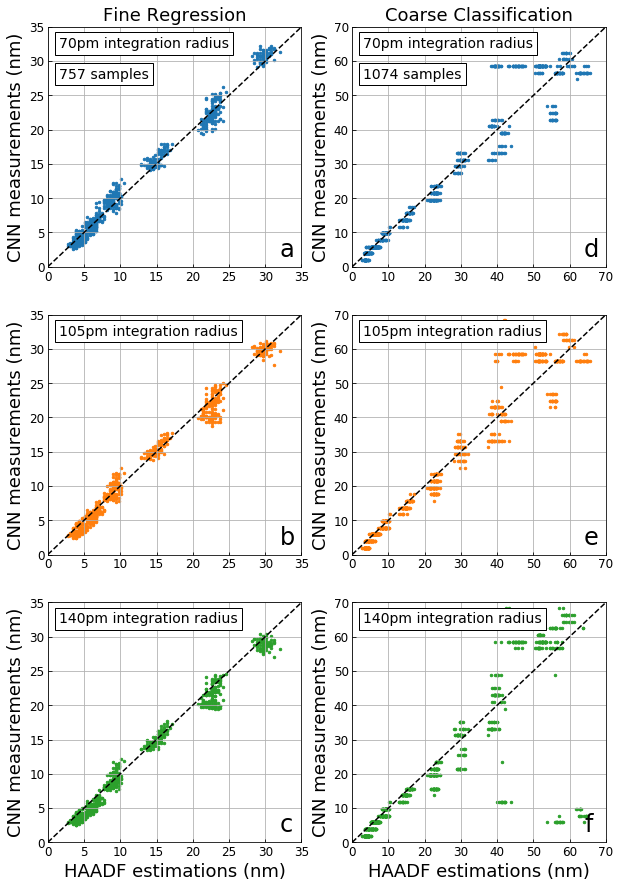

In [3]:
model_path = 'D:/2019/4DSTEM/CNN/Models/Regression/CoarseCNN/PartialTraining/35nm/attempt_5/'

fig = plt.figure(figsize=(10,15))

pred = np.load(model_path + 'prediction_r4_coarse_regression.npy')
truth = np.load(model_path + 'truth.npy')
fig.add_subplot(321)
plt.grid('on')
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='dashed',color='black')
plt.scatter(truth,pred,color='#1f77b4',s=6)
plt.xlim([0,35])
plt.ylim([0,35])
plt.tick_params(direction='in',labelsize=12)
plt.ylabel('CNN measurements (nm)',fontsize=18)
plt.text(1.5,32, '70pm integration radius', fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.text(1.5,27.5, '757 samples', fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.text(32,1.5, 'a', fontsize=24)
plt.title('Fine Regression',fontsize=18)

pred = np.load(model_path + 'prediction_r6_coarse_regression.npy')
truth = np.load(model_path + 'truth.npy')
fig.add_subplot(323)
plt.grid('on')
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='dashed',color='black')
plt.scatter(truth,pred,color='#ff7f0e',s=6)
plt.xlim([0,35])
plt.ylim([0,35])
plt.tick_params(direction='in',labelsize=12)
plt.ylabel('CNN measurements (nm)',fontsize=18)
plt.text(32,1.5, 'b', fontsize=24)
plt.text(1.5,32, '105pm integration radius', fontsize=14,bbox=dict(facecolor='white', alpha=1))

pred = np.load(model_path + 'prediction_r8_coarse_regression.npy')
truth = np.load(model_path + 'truth.npy')
fig.add_subplot(325)
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='dashed',color='black')
plt.scatter(truth,pred,color='#2ca02c',s=6)
plt.xlim([0,35])
plt.ylim([0,35])
plt.grid('on')
plt.tick_params(direction='in',labelsize=12)
plt.ylabel('CNN measurements (nm)',fontsize=18)
plt.xlabel('HAADF estimations (nm)', fontsize=18)
plt.text(1.5,32, '140pm integration radius', fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.text(32,1.5, 'c', fontsize=24)

# Coarse classification part

model_path = 'D:/2018/CNN/Predictions/CoarseSample/FinalOne/'

pred = np.load(model_path + 'prediction_r4_coarse_classification.npy')
truth = np.load(model_path + 'truth.npy')
fig.add_subplot(322)
plt.grid('on')
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='dashed',color='black')
plt.scatter(truth,pred,color='#1f77b4',s=6)
plt.xlim([0,70])
plt.ylim([0,70])
plt.tick_params(direction='in',labelsize=12)
plt.ylabel('CNN measurements (nm)',fontsize=18)
plt.text(3,64, '70pm integration radius', fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.text(3,55,'1074 samples', fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.title('Coarse Classification',fontsize=18)
plt.text(64,3, 'd', fontsize=24)

pred = np.load(model_path + 'prediction_r6_coarse_classification.npy')
truth = np.load(model_path + 'truth.npy')
fig.add_subplot(324)
plt.grid('on')
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='dashed',color='black')
plt.scatter(truth,pred,color='#ff7f0e',s=6)
plt.xlim([0,70])
plt.ylim([0,70])
plt.tick_params(direction='in',labelsize=12)
plt.ylabel('CNN measurements (nm)',fontsize=18)
plt.text(3,64, '105pm integration radius', fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.text(64,3, 'e', fontsize=24)

pred = np.load(model_path + 'prediction_r8_coarse_classification.npy')
truth = np.load(model_path + 'truth.npy')
fig.add_subplot(326)
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='dashed',color='black')
plt.scatter(truth,pred,color='#2ca02c',s=6)
plt.xlim([0,70])
plt.ylim([0,70])
plt.grid('on')
plt.tick_params(direction='in',labelsize=12)
plt.ylabel('CNN measurements (nm)',fontsize=18)
plt.xlabel('HAADF estimations (nm)', fontsize=18)
plt.text(3,64, '140pm integration radius', fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.text(64,3, 'f', fontsize=24)


## For tilted image series

D:/2019/4DSTEM/CNN/Exp_PACBED/033119_S9_tilted/


C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1.3331353664398193
Radius: 70.0, MSE: 51.65
D:/2019/4DSTEM/CNN/Exp_PACBED/033119_S9_tilted/
0.9928128719329834
Radius: 105.0, MSE: 66.83
D:/2019/4DSTEM/CNN/Exp_PACBED/033119_S9_tilted/
0.9909896850585938
Radius: 140.0, MSE: 81.54
Total 22 samples.


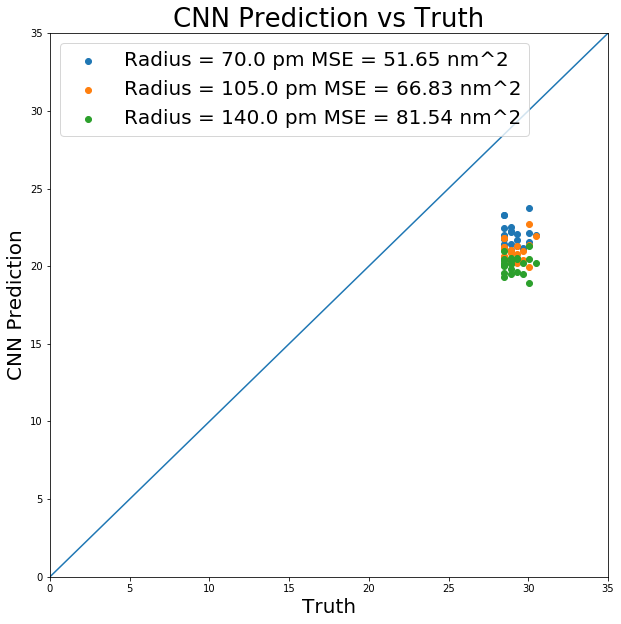

In [37]:

num_classes = 18    # For regression
class_thickness = 0.3905 * 5    # thickness step for each class in nm
batch_size = 36     # batch size during training
tilt_option = 1     # 0 to skip data with tilted PACBED
distorted_option = 0  # 0 to skip data with distorted PACBED
save_option = 1     # 0 to do plot only, 1 to save truth and prediction array for further plotting
# prediction range in nm
min_pred = 0
max_pred = 100
input_base = 'D:/2019/4DSTEM/CNN/Exp_PACBED/033119_S9_tilted/'
model_path = 'D:/2019/4DSTEM/CNN/Models/Regression/CoarseCNN/PartialTraining/35nm_more_augmentation/attempt_2/'   # Regression model for coarse CNN

# out_name = 'D:/2019/4DSTEM/CNN/Exp_Tilted/033119_S8/FinePrediction.npy'  # '071718_noise100_with_noiseless_predictions.mat'
radius_list = [4,6,8]

# Load model:
model = load_model(model_path + 'FinalModel.h5')

# Set up figure:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(111)
plt.title('CNN Prediction vs Truth',fontsize=26)

# Loop over all radii
for iradius in range(len(radius_list)):
    start = time.time()
    radius = radius_list[iradius]
    x_train_list = []
    y_train_list = []

    # Loop over all folders (thicknesses)
    for ifolder in range(len(glob(input_base))):
        input_folder = glob(input_base)[ifolder]

        if 'tilt' in input_folder and tilt_option == 0:
            continue

        input_images = [image for image in os.listdir(input_folder) if 'radius_' + str(radius) + '.npy' in image]
        print(input_folder)
        # Confirm this folder has and only has one file related to target radius:
        if len(input_images)==1:
            input_images = input_images[0]

            img_array = np.load(input_folder + input_images)
            label_array = np.load(input_folder + 'SrPeaks_thickness.npy')   # in unit of unit cells

            # prepare data to be looped through
            img_array = img_array.astype('double')
            im_range = img_array.shape[2]
            for i in range(im_range):
                label = label_array[i]  # label in uc
                if label * 0.3905 > 50:
                    print(input_folder)
                if label * 0.3905 > max_pred or label * 0.3905 < min_pred:
                    continue
                # prepare individual array to be formatted for prediction
                img = np.squeeze(img_array[:,:,i])
                img = scipy.misc.imresize(img, (160,160))
                img = img.astype('double')
                img = scale_range(img, 0, 1)

                # add image and labels to prediction arrays
                img_size = img.shape[0]
                new_channel = np.zeros((img_size, img_size))
                img_stack = np.dstack((img, new_channel, new_channel))


                x_train_list.append(img_stack)
                y_train_list.append(label)

    end = time.time()
    print(end-start)
    # Plot results for each integration radius

    # Print regression results, coarse CNN
    p_arrays = model.predict(np.asarray(x_train_list), batch_size=32)   # For regression
    p_arrays = np.squeeze(p_arrays)
    y_list = np.asarray(y_train_list).astype(float)
    pred = (p_arrays * (num_classes - 1) ) * class_thickness    # prediction in nm
    # For Jie's model, labels are directly in unit of nm
    MSE = np.mean((y_list * 0.3905 - pred )**2)
    print('Radius: ' + str(radius*17.5) + ', MSE: ' + '{:.2f}'.format(MSE) )
    plt.scatter(y_list * 0.3905, pred , label = 'Radius = ' + str(radius * 17.5) + \
                ' pm MSE = ' + '{:.2f}'.format(MSE) + ' nm^2')
    if save_option == 1:
        np.save(input_base + 'prediction_r' + str(radius_list[iradius]) + '_coarse_regression.npy', pred)

# if save_option == 1:
#     np.save(model_path + 'truth.npy',y_list * 0.3905)
#     print(y_list.shape)


# Add legends and labels after all radii processed
plt.legend(fontsize = 20)
plt.xlabel('Truth',fontsize=20)
plt.ylabel('CNN Prediction', fontsize=20)
plt.plot(np.linspace(0, 100, 1000),np.linspace(0, 100, 1000),linestyle='solid')
plt.xlim([0,35])
plt.ylim([0,35])
fig.savefig(model_path + 'Validation.png')
print("Total " + str(y_list.shape[0]) + ' samples.')

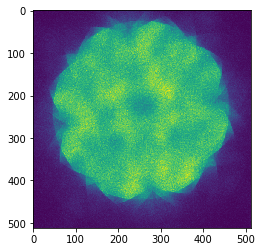

In [39]:
exp = np.load('D:/2019/4DSTEM/CNN/Exp_PACBED/071718_S4/PACBED_stack_radius_8.npy')
plt.imshow(exp[:,:,10])